<a href="https://www.kaggle.com/code/sohnoonmohamedomar/age-prediction-on-facial-images-with-pytorch?scriptVersionId=141583337" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path 
import random

import cv2
import matplotlib.pyplot as plt 
import seaborn as sns

import torch
import torch.nn as nn
from tqdm.notebook import tqdm 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set seed for reproducability
SEED = 1
random.seed(SEED)
np.random.seed(SEED)

# EDA

Store images paths and ages in a dataframe object.

In [3]:
image_dir = Path('../input/age-prediction/20-50/20-50') 
filepaths = pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath').astype(str)
ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int)
images = pd.concat([filepaths, ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
images.head()

,Filepath,Age
0,../input/age-prediction/20-50/20-50/test/38/41...,38
1,../input/age-prediction/20-50/20-50/train/39/1...,39
2,../input/age-prediction/20-50/20-50/train/30/1...,30
3,../input/age-prediction/20-50/20-50/train/42/1...,42
4,../input/age-prediction/20-50/20-50/train/35/1...,35


Explore some images

In [4]:
image = cv2.imread('/kaggle/input/age-prediction/20-50/20-50/test/28/38683.jpg')
image.shape

(128, 128, 3)

Age: 30


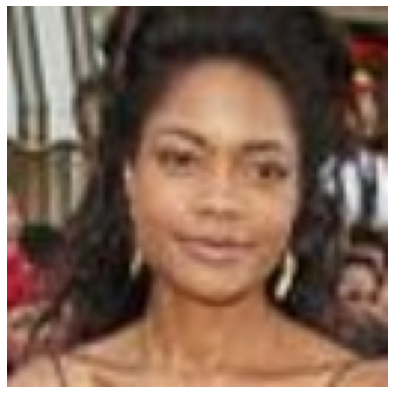

In [5]:
def visualize(image):
    plt.figure(figsize=(7, 7))
    plt.axis('off')
    plt.imshow(image)

#choose an image id to see its age
image_id = 4000
image_example_path = images.iloc[image_id].Filepath
age = images.iloc[image_id].Age

print(f'Age: {age}')
image = cv2.imread(image_example_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

See target distribution

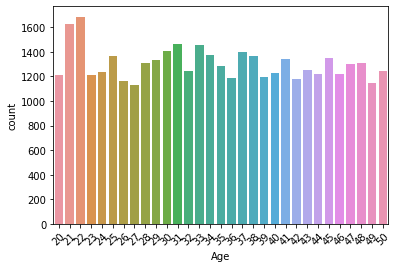

In [6]:
sns.countplot(images.Age)
plt.xticks(rotation = 45);

We will go for a 31-class classification approach:<br>
class 0 : 20 years <br>
...<br>
class 31 : 50 years

In [7]:
# Adjust target
images.Age = images.Age-20

# Prepare Data

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(images, test_size = 0.1, random_state = SEED)
train, valid = train_test_split(train, test_size = 0.2, random_state = SEED)

## Dataset class

In [9]:
class ImageAgeDataset() : 
  def __init__(self , images) : 
    self.age = images.Age.values
    self.paths = images.Filepath.values 

  def __len__(self) : 
    return len(self.age)

  def __getitem__(self , item) : 
    out = dict()
    path = self.paths[item] 
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image , dtype = float)
    out['x'] = torch.tensor(image , dtype = torch.float).permute(2,0,1)/255 
    out['y'] = torch.tensor(self.age[item], dtype= torch.long) #CrossEntropyLoss()'s forward(probs, y) function requires torch.long for y
    return out 

In [10]:
train_dataset = ImageAgeDataset(train) 
valid_dataset = ImageAgeDataset(valid)

# Model

In [11]:
class AlexNetwork(nn.Module):
    def __init__(self, n_classes):
        super(AlexNetwork, self).__init__()
        self.n_classes = n_classes
        self.conv_1 = nn.Conv2d(
            in_channels = 3,
            out_channels = 96,
            kernel_size = 11,
            stride = 4,
            padding = 50
        )
        self.pool_1 = nn.MaxPool2d(
        kernel_size = 3, 
        stride = 2,
        )
        self.conv_2 = nn.Conv2d(
            in_channels = 96,
            out_channels = 256,
            kernel_size = 5,
            stride = 1,
            padding = 2
        )  
        self.pool_2 = nn.MaxPool2d(
        kernel_size = 3, 
        stride = 2,
        )
        self.conv_3 = nn.Conv2d(
            in_channels = 256,
            out_channels = 384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )  
        self.conv_4 = nn.Conv2d(
            in_channels = 384,
            out_channels = 384,
            kernel_size = 3,
            stride = 1,
            padding = 1
        )  
        self.conv_5 = nn.Conv2d(
            in_channels = 384,
            out_channels = 256,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ) 
        self.pool_3 = nn.MaxPool2d(
        kernel_size = 3, 
        stride = 2,
        )
        self.nn = nn.Sequential(nn.Linear(in_features = 9216, out_features = 4096),
                                nn.ReLU(),
                                nn.Linear(in_features = 4096, out_features = 4096),
                                nn.ReLU(),
                                nn.Linear(in_features = 4096, out_features = self.n_classes),
                               )
    def forward(self, x):
        x = self.conv_1(x)
        x = self.pool_1(x)
        x = self.conv_2(x)
        x = self.pool_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.conv_5(x)
        x = self.pool_3(x)
        x = x.view(-1,9216)
        x = self.nn(x)
        return x  

# Engine

In [12]:
#hparams
DEVICE = 'cuda' 
BATCH_SIZE = 50
MAX_WAIT = 3
EPOCHS = 100
LR = 1e1

#---------------------
train_dataloader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE, 
    shuffle = True ,
    num_workers = 8
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset = valid_dataset,
    batch_size = BATCH_SIZE, 
    shuffle = False,
    num_workers = 8
)

#---------------------
model = AlexNetwork(31)
model.to(DEVICE)

#---------------------
loss_fn = nn.CrossEntropyLoss()

#---------------------
optimizer = torch.optim.Adam(params = model.parameters(), lr = LR)

#---------------------
def train_step(model , optimizer , dataloader): 
  model.train()
  total_loss = 0 
  for data in tqdm(dataloader): 
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    y_hat = model(x).to(DEVICE) #to apply model(x), x and model must be in the same place (device)
    loss = loss_fn(y_hat , y) #enough for y_hat and y to be in the same device
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    total_loss += loss.item()
  #total_loss.backward()
  #optimizer.step()
  #optimizer.zero_grad()
  return total_loss/len(dataloader)

def valid_step(model, dataloader): 
  model.eval()
  total_loss = 0 
  for data in tqdm(dataloader): 
    x = data["x"].to(DEVICE)
    y = data["y"].to(DEVICE)
    with torch.no_grad():
      y_hat = model(x).to(DEVICE)
      loss = loss_fn(y_hat , y) 
    total_loss += loss.item()
  return total_loss/len(dataloader)

def main(model , optimizer , train_dataloader , valid_dataloader ): 
  train_losses = []
  valid_losses = [] 
  min_valid_loss = np.inf 
  patience = 0 
  for epoch in range(EPOCHS): 
    train_loss = train_step(model , optimizer , train_dataloader)
    train_losses.append(train_loss)  
    valid_loss = valid_step(model , valid_dataloader)
    valid_losses.append(valid_loss)
    print(f'EPOCH = {epoch}')
    print(f'train_loss = {train_loss}')
    print(f'valid_loss = {valid_loss}')
    if valid_loss > min_valid_loss : 
      patience += 1 
    else: 
      min_valid_loss = valid_loss 
      patience = 0 

    if patience > MAX_WAIT : 
      print(f'EARLY STOPPING AT EPOCH = {epoch}')
      break 
  return train_losses , valid_losses 
        

In [13]:
train_losses, valid_losses = main(
    model = model, 
    optimizer = optimizer, 
    train_dataloader = train_dataloader,
    valid_dataloader = valid_dataloader
)

  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 0
train_loss = 2.1105132834389083e+26
valid_loss = 6.535936587375742e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 1
train_loss = 7.56916982951355e+25
valid_loss = 6.245350440396289e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 2
train_loss = 6.204816442637293e+25
valid_loss = 4.17970371449641e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 3
train_loss = 2.5954413472973174e+25
valid_loss = 1.9841571655276956e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 4
train_loss = 1.7494985685657939e+25
valid_loss = 1.5097602179367178e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 5
train_loss = 4.230436997175696e+25
valid_loss = 6.812630492972629e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 6
train_loss = 2.7642659522240144e+25
valid_loss = 1.8147968291752803e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 7
train_loss = 1.5863770129651744e+25
valid_loss = 1.4424955886613546e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 8
train_loss = 2.6821374805715576e+25
valid_loss = 2.244378986250838e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 9
train_loss = 1.8285921258389977e+25
valid_loss = 1.6725384476366146e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 10
train_loss = 1.6138504963355613e+25
valid_loss = 2.1569711836684077e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 11
train_loss = 3.348735685457726e+25
valid_loss = 1.3716817651580881e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 12
train_loss = 1.4717942130829777e+25
valid_loss = 1.0400414712485883e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 13
train_loss = 1.1881769779445423e+25
valid_loss = 1.066584782290478e+25


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 14
train_loss = 8.207752981577565e+24
valid_loss = 8.426759466301349e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 15
train_loss = 7.059129569328675e+24
valid_loss = 7.511222908303441e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 16
train_loss = 6.479485656617298e+24
valid_loss = 7.352904280061413e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 17
train_loss = 5.995123403601493e+24
valid_loss = 6.735169155052937e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 18
train_loss = 5.691919891012677e+24
valid_loss = 6.558487563015988e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 19
train_loss = 5.43207206872971e+24
valid_loss = 6.283877829158231e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 20
train_loss = 5.243842333656295e+24
valid_loss = 6.618257414418488e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 21
train_loss = 5.027160986100306e+24
valid_loss = 6.236912377288772e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 22
train_loss = 4.8419294545463e+24
valid_loss = 6.13979029540504e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 23
train_loss = 4.708918560727223e+24
valid_loss = 5.905265741126488e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 24
train_loss = 4.544522285474181e+24
valid_loss = 5.92079345575589e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 25
train_loss = 4.4232859283250494e+24
valid_loss = 6.052703747687654e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 26
train_loss = 4.3472785962718755e+24
valid_loss = 5.673849352670241e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 27
train_loss = 4.2203850589665957e+24
valid_loss = 5.589916947468516e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 28
train_loss = 4.124098933219452e+24
valid_loss = 5.467419803586134e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 29
train_loss = 4.017656887559454e+24
valid_loss = 5.442779687588877e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 30
train_loss = 3.9386224058457167e+24
valid_loss = 5.350609901060957e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 31
train_loss = 3.884015613637673e+24
valid_loss = 5.377663168631305e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 32
train_loss = 3.788249696010682e+24
valid_loss = 5.379900720783177e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 33
train_loss = 3.729612296402429e+24
valid_loss = 5.371878604115994e+24


  0%|          | 0/583 [00:00<?, ?it/s]

  0%|          | 0/146 [00:00<?, ?it/s]

EPOCH = 34
train_loss = 3.668856143232218e+24
valid_loss = 5.370960570626144e+24
EARLY STOPPING AT EPOCH = 34


# Evaluation

In [14]:
def pred(x):
    for i in range(len(x[0])):
        if (x[0][i] == torch.max(x[0]).item()): 
            return i
test_dataset = ImageAgeDataset(test)
softmax = nn.Softmax()
model.eval()
y_pred = np.array([pred(softmax(model(test_dataset[id]['x'].to(DEVICE))))+20 for id in range(len(test))])
y_true = test.Age.values

In [15]:
accuracy_score(y_true, y_pred)

0.008654797230464886

Not that bad ;)

image 10 is 43 years old and is predicted 50 years old


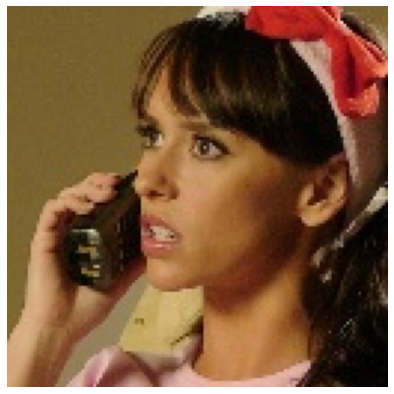

In [16]:
#play around.. choose an id from 0 to 4043 to test the model on :)
id = 10
softmax = nn.Softmax()
model.eval()
y_hat_id = softmax(model(test_dataset[id]['x'].to(DEVICE)))
true_age = train_dataset[id]['y'].item() + 20
print(f'image {id} is {true_age} years old and is predicted {pred(y_hat_id)+20} years old')
image = cv2.imread(test.iloc[id].Filepath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize(image)

# Save the model for further use

In [17]:
path = 'alexnetwork.pth'
torch.save(model, path)